# 🧠 Тема: Побудова кастомного датасету


## ✅ Завдання:
### 1. Створи датасет з 2–3 класами
- Сфоткай або знайди в інтернеті 10–20 зображень для кожного класу

  - Наприклад: "пляшка", "книга", "телефон"

- Розклади у форматі:

/my_dataset/<br />
&nbsp;&nbsp;&nbsp;&nbsp;/bottle/<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;img1.jpg<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;img2.jpg<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...<br />
&nbsp;&nbsp;&nbsp;&nbsp;    /book/<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;img1.jpg<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...<br />
&nbsp;&nbsp;&nbsp;&nbsp;   /phone/<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...


In [142]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
import torch.optim as optim



### 2. Завантаж кастомний датасет у PyTorch

In [143]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dir = 'my_dataset/banana'
test_dir = 'my_dataset/test'  


train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

class_names = train_dataset.classes
class_names

['banana']

In [144]:
test_classes = test_dataset.classes  
test_classes

['banana', 'not_banana']

### 3. Виведи приклади зображень


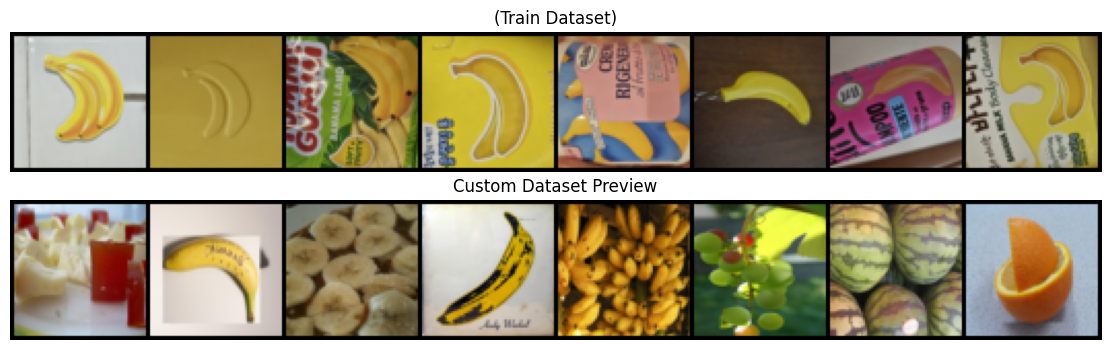

In [145]:
images_1, labels = next(iter(train_loader))
images_2, labels = next(iter(test_loader))

fig, axes = plt.subplots(2, 1, figsize=(15, 4))  # Создаем subplot с 2 строками и 1 колонкой

# Отображение images_1 на верхнем subplot
grid_1 = torchvision.utils.make_grid(images_1)
axes[0].imshow(grid_1.permute(1, 2, 0))
axes[0].set_title("(Train Dataset)")
axes[0].axis('off')

# Отображение images_2 на нижнем subplot
grid_2 = torchvision.utils.make_grid(images_2)
axes[1].imshow(grid_2.permute(1, 2, 0))
axes[1].set_title("(Test Dataset)")
axes[1].axis('off')

plt.title("Custom Dataset Preview")
plt.axis('off')
plt.show()

### 🎯 Bonus:
- Розділи my_dataset на /train/ і /val/

- Побудуй CNN і натренуй її розпізнавати твої класи (мінімум 3 епохи)

In [146]:
class BananaCNN(nn.Module):
    def __init__(self):
        super(BananaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 1)  # Один выход

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # (3, 64, 64) → (16, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))   # → (32, 16, 16)
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # 0..1 — вероятность банана
        return x

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BananaCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

def accuracy_fn(y_true, y_pred):
    return (y_true == y_pred).sum().item() / len(y_true)

In [148]:
train_loss_values, train_acc_values = [], []
test_loss_values, test_acc_values = [], []

for epoch in range(3):
    # TRAIN
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Normalize labels to be in the range [0, 1]
        labels = torch.ones(inputs.size(0), 1).to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        running_acc += accuracy_fn(labels, preds)

    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    # EVAL
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = torch.ones(inputs.size(0), 1).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            preds = (outputs > 0.5).float()
            test_acc += accuracy_fn(labels, preds)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    test_loss_values.append(test_loss)
    test_acc_values.append(test_acc)


    print(f"Raw: {outputs.squeeze().tolist()}")
    print(f"Predicted: {['banana' if p==1 else 'not banana' for p in preds.squeeze()]}")
    print(f"Epoch {epoch+1}/{3} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

Raw: [0.898422122001648, 0.9462526440620422, 0.8087509274482727, 0.9376736879348755, 0.8243265151977539, 0.8102607727050781, 0.8630366325378418, 0.9045512080192566]
Predicted: ['banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana']
Epoch 1/3 | Train Loss: 0.5162 Acc: 1.0000 | Test Loss: 0.1363 Acc: 1.0000
Raw: [0.9974415302276611, 0.9996472597122192, 0.9844277501106262, 0.9994416832923889, 0.9862824082374573, 0.9837517738342285, 0.994773805141449, 0.997808039188385]
Predicted: ['banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana']
Epoch 2/3 | Train Loss: 0.1100 Acc: 1.0000 | Test Loss: 0.0071 Acc: 1.0000
Raw: [0.9999819993972778, 0.9999995231628418, 0.9996349811553955, 0.999998927116394, 0.9996657371520996, 0.9995561242103577, 0.9999483823776245, 0.9999861717224121]
Predicted: ['banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana', 'banana']
Epoch 3/3 | Train Loss: 0.0090 Acc: 1.0000 | Test Loss: 0.0002 Acc: 1.0000


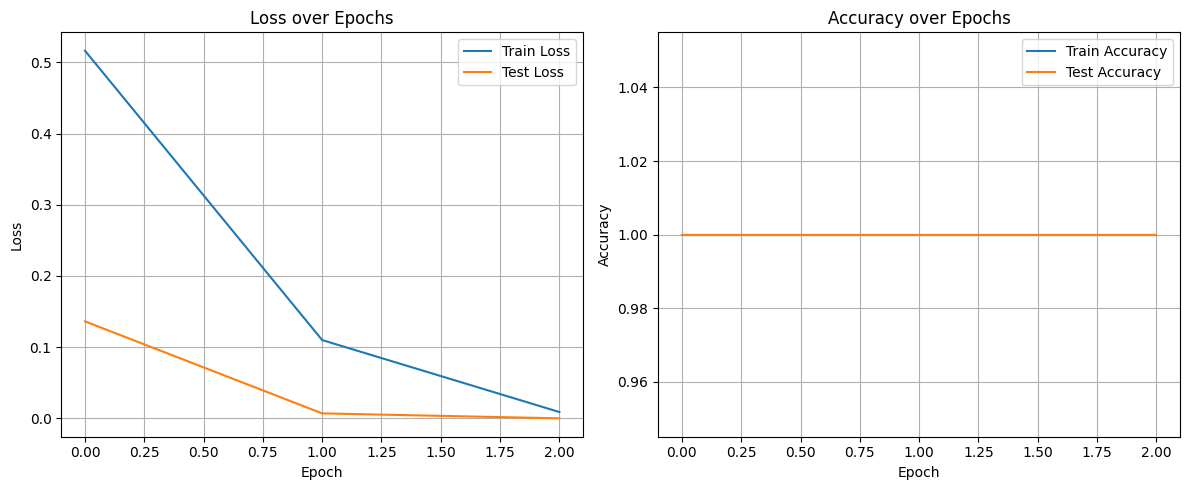

In [149]:
# PLOT
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label="Train Loss")
plt.plot(test_loss_values, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label="Train Accuracy")
plt.plot(test_acc_values, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

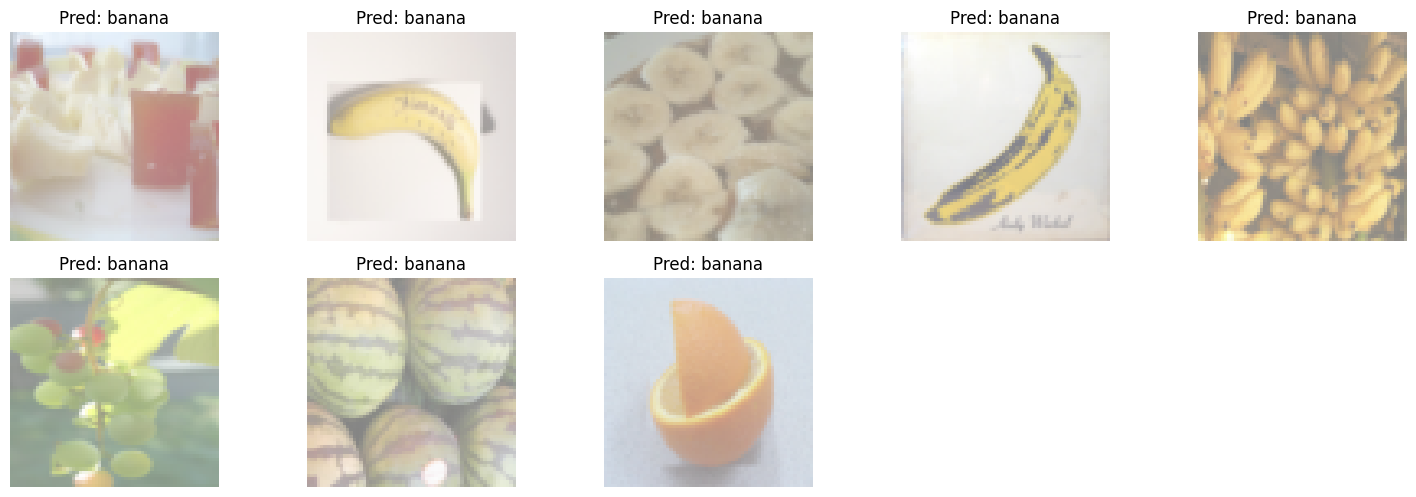

Accuracy for class: not banana — 0.0 %
Accuracy for class: banana  — 100.0 %


In [150]:
def show_predictions(model, dataloader, classes, device='cpu'):
    model.eval()
    images_shown = 0
    max_images = 10
    plt.figure(figsize=(15, 10))

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            labels_float = labels.float().unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).int().squeeze(1)

            # Отображение изображений
            for i in range(images.size(0)):
                if images_shown >= max_images:
                    break

                img = images[i].cpu() / 2 + 0.5  # unnormalize
                npimg = img.numpy().transpose((1, 2, 0))

                pred_label = classes[int(preds[i].item())]

                plt.subplot(4, 5, images_shown + 1)
                plt.imshow(npimg)
                plt.title(f'Pred: {pred_label}')
                plt.axis('off')

                images_shown += 1

            # Подсчёт статистики
            for label, prediction in zip(labels, preds):
                label_idx = int(label.item())
                pred_idx = int(prediction.item())

                total_pred[classes[label_idx]] += 1
                if label_idx == pred_idx:
                    correct_pred[classes[label_idx]] += 1

            if images_shown >= max_images:
                break

    plt.tight_layout()
    plt.show()

    # Печать точности
    for classname, correct_count in correct_pred.items():
        total = total_pred[classname]
        if total > 0:
            accuracy = 100 * float(correct_count) / total
            print(f'Accuracy for class: {classname:7s} — {accuracy:.1f} %')
        else:
            print(f'No samples for class: {classname}')


classes = ['not banana', 'banana']
show_predictions(model, test_loader, classes, device)